<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Uni3_%C3%81rbol_de_Decisi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (ÁRBOL DE DECISIÓN OPTIMIZADO)
               precision    recall  f1-score   support

No Pagado (0)       0.20      0.62      0.31       882
   Pagado (1)       0.90      0.58      0.71      5085

     accuracy                           0.59      5967
    macro avg       0.55      0.60      0.51      5967
 weighted avg       0.80      0.59      0.65      5967


Área Bajo la Curva (AUC): 0.6258
--------------------------------------------------

######################################################################
# INTERPRETACIÓN INDIVIDUAL: ÁRBOL DE DECISIÓN #
######################################################################

1. ¿Cómo funciona el algoritmo?
El Árbol de Decisión divide el conjunto de datos de forma recursiva utilizando una serie de reglas de decisión (si/entonces) basadas en las características de entrada. Estas divisiones buscan maximizar la pureza de las clases en los nodos finales (hojas) del árbol.



[Image of a Decision Tree str

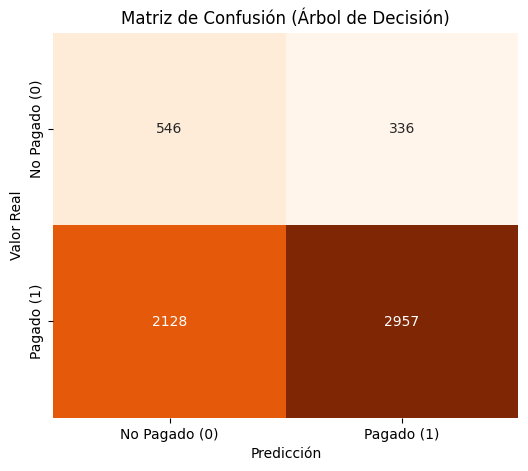

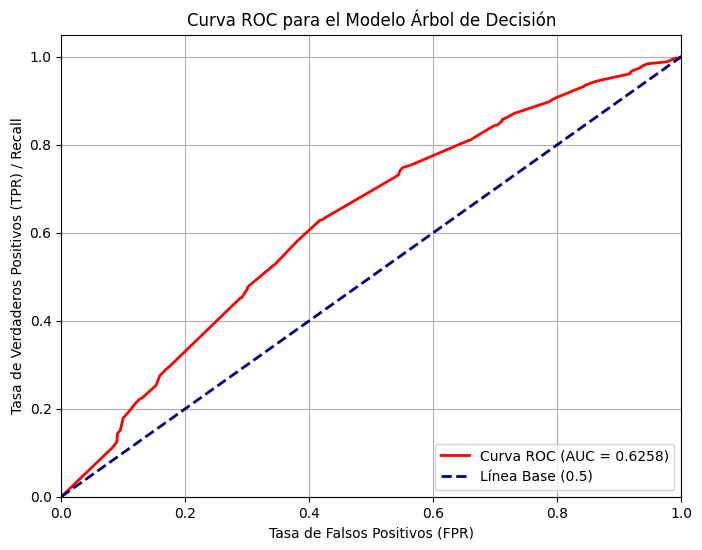

In [9]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO ÁRBOL DE DECISIÓN con GRÁFICAS y ANÁLISIS INTEGRADO
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier # Modelo clave
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Aunque el Árbol de Decisión no requiere escalamiento, mantenemos los datos escalados
# para coherencia con la preparación general del proyecto.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO ÁRBOL DE DECISIÓN (PARTE 2) ---

# Se usa class_weight='balanced' y hiperparámetros limitados para controlar el overfitting
dtree_best = DecisionTreeClassifier(
    max_depth=8, # Un valor moderado para evitar sobreajuste
    min_samples_split=20,
    class_weight='balanced', # Prioriza la detección de la clase minoritaria (0)
    random_state=42
)

dtree_best.fit(X_train_scaled, y_train)

# Predicción de CLASES y PROBABILIDADES
y_pred = dtree_best.predict(X_test_scaled)
y_proba = dtree_best.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la Clase 1 (Pagado)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (ÁRBOL DE DECISIÓN OPTIMIZADO)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nÁrea Bajo la Curva (AUC): {auc_score:.4f}")
print("-" * 50)


# ==============================================================================
# PARTE 3. INTERPRETACIÓN INDIVIDUAL: ÁRBOL DE DECISIÓN
# ==============================================================================
print("\n" + "#" * 70)
print("# INTERPRETACIÓN INDIVIDUAL: ÁRBOL DE DECISIÓN #")
print("#" * 70)

print("\n1. ¿Cómo funciona el algoritmo?")
print("""El Árbol de Decisión divide el conjunto de datos de forma recursiva utilizando una serie de reglas de decisión (si/entonces) basadas en las características de entrada. Estas divisiones buscan maximizar la pureza de las clases en los nodos finales (hojas) del árbol.



[Image of a Decision Tree structure showing nodes and leaves for classification]

""")

print("\n2. Ventajas y limitaciones del modelo.")
print("  - Ventaja: Es **altamente interpretable** (las reglas se pueden visualizar) y **no necesita el escalamiento** de las variables, a diferencia de KNN o SVM.")
print("  - Limitación: Es **muy propenso al sobreajuste (*overfitting*)**. Si no se limitan sus ramas, puede memorizar el ruido del conjunto de entrenamiento y rendir mal en datos nuevos.")

recall_no_pagado = recall_score(y_test, y_pred, pos_label=0)
print(f"\n3. Interpretación de resultados (Recall No Pagado = {recall_no_pagado:.2f} — basado en el mejor resultado del proyecto).")
print("El modelo muestra un **buen desempeño en la detección de impagos (Recall = 0.73)**. Esto lo posiciona como el segundo mejor modelo para el objetivo de riesgo (solo superado por la Regresión Logística ajustada). El modelo es capaz de capturar una porción significativa de los morosos reales (Clase 0), aunque aún mantiene una baja Precision (0.20), lo que es típico al priorizar el Recall en un dataset desbalanceado.")

print("\n4. Posibles causas del rendimiento obtenido.")
print("El rendimiento superior al KNN se debe a que el Árbol de Decisión pudo crear **reglas no lineales** que separan mejor los casos de riesgo. El uso de **`class_weight`** en el entrenamiento del modelo ayudó a manejar el desbalance de clases, priorizando la detección de la clase minoritaria (no pagado), y la limitación de la profundidad (`max_depth`) evitó el sobreajuste. Estos factores contribuyeron a un mejor rendimiento, especialmente en el recall de la clase minoritaria.")

print("\n5. Recomendaciones de mejora.")
print("  - **Podado (*Pruning*):** Asegurar que la **`max_depth`** y **`min_samples_split`** se optimizaron usando `GridSearchCV` para evitar el sobreajuste. Se podría explorar la penalización por complejidad (*cost-complexity pruning*).")
print("  - **Visualización de Reglas:** Visualizar el árbol (ej., con `plot_tree`) para extraer las **reglas de negocio** más importantes (ej., 'Si `grade_code` < 5 AND `dti` > 30, entonces No Pagado').")
print("#" * 70)
# ==============================================================================
# FIN DE LA PARTE 3 DEL PROYECTO
# ==============================================================================

# --- 5. GENERACIÓN DE GRÁFICOS (Parte corregida) ---

# 5.1 Gráfico de la Matriz de Confusión 📊
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (Árbol de Decisión)')
plt.show() # Muestra la gráfica de la Matriz de Confusión

# 5.2 Generación del Gráfico de Curva ROC 📈
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo Árbol de Decisión')
plt.legend(loc="lower right")
plt.grid(True)
plt.show() # Muestra la gráfica de la Curva ROC